# Simulation of metaheuristic selecting neural learners with varying plasticity (remodelling pace).
## Implements:
- population of logistic-regression "neural" agents sharing architecture (weights), each with plasticity p
- online task stream of drifting Gaussian classification tasks
- selector (metaheuristic) that assigns best agents to each task based on estimated MetaFitness (EMA)
- evaluation metrics and results tables


In [130]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
import random
import math
import io, os, sys


In [131]:
# Seed for reproducibility
SEED = 40
np.random.seed(SEED)
random.seed(SEED)

In [132]:
# --- Task generator: drifting 2D Gaussian classification task ---
class DriftingGaussianTaskStream:
    """
    Binary classification tasks defined by two Gaussian blobs in 2D.
    The center means drift over time by random walk.
    Each task instance t has parameter z_t (mean offset).
    """
    def __init__(self, drift_scale=0.05, noise_scale=0.1):
        self.drift_scale = drift_scale
        self.noise_scale = noise_scale
        # initial means for class 0 and 1
        self.mu0 = np.array([-1.0, 0.0])
        self.mu1 = np.array([1.0, 0.0])
    
    def step(self):
        # random walk drift applied to both means
        delta0 = np.random.normal(scale=self.drift_scale, size=2)
        delta1 = np.random.normal(scale=self.drift_scale, size=2)
        self.mu0 += delta0
        self.mu1 += delta1
    
    def sample(self, n=200):
        # sample balanced classes with given noise
        x0 = np.random.normal(loc=self.mu0, scale=self.noise_scale, size=(n//2, 2))
        x1 = np.random.normal(loc=self.mu1, scale=self.noise_scale, size=(n - n//2, 2))
        X = np.vstack([x0, x1])
        y = np.array([0]*(n//2) + [1]*(n - n//2))
        # shuffle
        perm = np.random.permutation(n)
        return X[perm], y[perm]

In [133]:
# --- Simple logistic regression "neural" agent with plasticity parameter p ---
@dataclass
class Agent:
    id: int
    dim: int = 2
    p: float = 0.5  # plasticity (0..1). low p = stable, high p = plastic
    weights: np.ndarray = field(default_factory=lambda: None)
    memory: np.ndarray = field(default_factory=lambda: None)  # consolidated memory
    ema_score: float = 0.0  # EMA of meta-fitness (used by selector)
    alpha0: float = 0.5  # base learning rate scale
    lambda0: float = 0.2  # consolidation base weight for stable agents
    age: int = 0
    history_scores: List[float] = field(default_factory=list)

    def __post_init__(self):
        if self.weights is None:
            # initialize small weights and bias as last element
            self.weights = np.random.normal(scale=0.1, size=(self.dim+1,))
        if self.memory is None:
            self.memory = self.weights.copy()

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        Xb = np.hstack([X, np.ones((X.shape[0],1))])
        logits = Xb.dot(self.weights)
        probs = 1.0 / (1.0 + np.exp(-logits))
        return probs

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X) > 0.5).astype(int)

    def adapt(self, X: np.ndarray, y: np.ndarray, steps=10, batch_size=32):
        """
        Online adaptation for current task. Effective learning rate scales with p.
        Also apply consolidation toward memory with strength lambda(p) after adaptation.
        """
        n = X.shape[0]
        lr = 0.01 * (0.2 + 1.6 * self.p)  # learning rate: increases with p
        # SGD logistic loss
        for _ in range(steps):
            idx = np.random.choice(n, size=min(batch_size, n), replace=False)
            xb = np.hstack([X[idx], np.ones((len(idx),1))])
            probs = 1.0 / (1.0 + np.exp(-xb.dot(self.weights)))
            grad = xb.T.dot(probs - y[idx]) / len(idx)
            self.weights -= lr * grad
        # consolidation: stable agents (low p) pull weights toward memory more strongly.
        lam = self.lambda0 * (1.0 - self.p)  # higher when p low
        self.weights = (1 - lam) * self.weights + lam * self.memory
        # optionally update memory slowly for plastic agents (simulate reconsolidation)
        memory_update_rate = 0.01 * self.p  # plastic agents update memory more
        self.memory = (1 - memory_update_rate) * self.memory + memory_update_rate * self.weights
        self.age += 1

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        acc = (preds == y).mean()
        self.history_scores.append(acc)
        return acc

In [134]:
# --- Selector (metaheuristic) ---
class MetaSelector:
    """
    Maintains EMA estimates of each agent's MetaFitness and selects top-k agents for each task.
    Updates estimates based on observed scores.
    """
    def __init__(self, agents: List[Agent], k=3, ema_alpha=0.2, gamma=0.6):
        self.agents = agents
        self.k = k
        self.ema_alpha = ema_alpha
        self.gamma = gamma  # weight between immediate performance and robustness

        # initialize EMA scores modestly
        for a in agents:
            a.ema_score = 0.5

    def select(self, task_features=None) -> List[Agent]:
        # pick top-k by ema_score (ties random)
        sorted_agents = sorted(self.agents, key=lambda a: a.ema_score, reverse=True)
        selected = sorted_agents[:self.k]
        return selected

    def update(self, selected: List[Agent], scores: List[float], robustness: List[float]):
        # observed metafitness = gamma * immediate + (1-gamma)*robustness
        for a, s, r in zip(selected, scores, robustness):
            meta = self.gamma * s + (1 - self.gamma) * r
            # EMA update
            a.ema_score = (1 - self.ema_alpha) * a.ema_score + self.ema_alpha * meta


In [135]:
# --- Population dynamics ---
def maybe_introduce_new_agents(agents: List[Agent], prob_new=0.05, p_prior=(0.0,1.0), dim=2):
    if np.random.rand() < prob_new:
        new_id = max([a.id for a in agents]) + 1
        p_new = np.clip(np.random.beta(2,2) * (p_prior[1]-p_prior[0]) + p_prior[0], 0.0, 1.0)
        new_agent = Agent(id=new_id, dim=dim, p=p_new)
        agents.append(new_agent)
        return new_agent
    return None

def maybe_remove_agent(agents: List[Agent], remove_prob=0.01):
    # remove very low EMA agents occasionally
    if np.random.rand() < remove_prob and len(agents) > 3:
        emas = np.array([a.ema_score for a in agents])
        idx = np.argmin(emas)
        rem = agents.pop(idx)
        return rem
    return None


In [136]:
# --- Simulation parameters ---
N_INIT = 12
T = 100  # number of iterations / tasks
k_select = 3  # how many agents are selected per task
task_stream = DriftingGaussianTaskStream(drift_scale=0.05, noise_scale=0.2)

In [137]:
# initialize population with diverse p values
agents: List[Agent] = []
ps = np.linspace(0, 1, N_INIT)
for i in range(N_INIT):
    a = Agent(id=i, dim=2, p=float(ps[i]))
    agents.append(a)

In [138]:
selector = MetaSelector(agents=agents, k=k_select, ema_alpha=0.15, gamma=0.6)


In [139]:
# track metrics across time
records = []
# maintain a small validation set of previous tasks to compute robustness
past_task_validations: List[Tuple[np.ndarray, np.ndarray]] = []

for t in range(T):
    # step task drift and sample dataset
    task_stream.step()
    X_train, y_train = task_stream.sample(n=200)
    X_val, y_val = task_stream.sample(n=200)
    # also keep latest val in memory for robustness
    past_task_validations.append((X_val.copy(), y_val.copy()))
    if len(past_task_validations) > 10:
        past_task_validations.pop(0)  # window of 10 past tasks

    # select agents
    selected_agents = selector.select(task_features=None)

    # adapt selected agents to current task
    immediate_scores = []
    robustness_scores = []
    for a in selected_agents:
        a.adapt(X_train, y_train, steps=8, batch_size=32)
        score = a.evaluate(X_val, y_val)
        # robustness: average performance over window of past validations
        if len(past_task_validations) > 1:
            rs = [a.evaluate(Xv, yv) for (Xv, yv) in past_task_validations[:-1]]
            robustness = np.mean(rs)
        else:
            robustness = score
        immediate_scores.append(score)
        robustness_scores.append(robustness)
    # update selector EMA estimates
    selector.update(selected_agents, immediate_scores, robustness_scores)

    # population dynamics: occasional births/deaths
    maybe_introduce_new_agents(agents, prob_new=0.08, p_prior=(0.0,1.0))
    maybe_remove_agent(agents, remove_prob=0.03)

    # record snapshot metrics
    avg_p_selected = np.mean([a.p for a in selected_agents])
    avg_ema = np.mean([a.ema_score for a in agents])
    avg_perf_selected = np.mean(immediate_scores)
    records.append({
        "t": t,
        "avg_p_selected": avg_p_selected,
        "avg_ema": avg_ema,
        "avg_perf_selected": avg_perf_selected,
        "num_agents": len(agents)
    })



In [140]:
# Convert records to dataframe
df_records = pd.DataFrame(records)


In [141]:
# Summary tables by plasticity quantiles: compute mean performance on a held-out stationary test over last tasks
# Build a held-out test from final task stream state
X_test, y_test = task_stream.sample(n=1000)
performance_rows = []
for a in agents:
    perf = a.evaluate(X_test, y_test)
    performance_rows.append({"agent_id": a.id, "p": a.p, "age": a.age, "ema": a.ema_score, "test_acc": perf})


In [142]:

df_perf = pd.DataFrame(performance_rows)
df_perf['p_group'] = pd.cut(df_perf['p'], bins=[-0.01, 0.33, 0.66, 1.01], labels=["low_p", "mid_p", "high_p"])


In [143]:
# aggregate
agg = df_perf.groupby('p_group').agg(mean_test_acc=('test_acc','mean'), mean_ema=('ema','mean'), count=('agent_id','count')).reset_index()


/tmp/ipykernel_35059/689952820.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_perf.groupby('p_group').agg(mean_test_acc=('test_acc','mean'), mean_ema=('ema','mean'), count=('agent_id','count')).reset_index()


In [144]:
df_records

,t,avg_p_selected,avg_ema,avg_perf_selected,num_agents
0,0,0.090909,0.511250,0.800000,12
1,1,0.181818,0.527516,0.975000,12
2,2,0.181818,0.541591,0.991667,12
3,3,0.181818,0.553364,0.981667,12
4,4,0.181818,0.563631,0.993333,12
...,...,...,...,...,...
95,95,0.181818,0.405561,0.965000,18
96,96,0.181818,0.406296,0.978333,18
97,97,0.181818,0.406977,0.976667,18
98,98,0.181818,0.407533,0.973333,18


In [145]:
df_perf

,agent_id,p,age,ema,test_acc,p_group
0,0,0.000000,1,0.487250,0.500,low_p
1,1,0.090909,100,0.882388,0.979,low_p
2,2,0.181818,100,0.977560,0.942,low_p
3,3,0.272727,99,0.993632,0.980,low_p
4,4,0.363636,0,0.500000,0.517,mid_p
5,5,0.454545,0,0.500000,0.500,mid_p
6,6,0.545455,0,0.500000,0.262,mid_p
7,7,0.636364,0,0.500000,0.500,mid_p
8,8,0.727273,0,0.500000,0.500,high_p
9,9,0.818182,0,0.500000,0.500,high_p


In [146]:
agg

,p_group,mean_test_acc,mean_ema,count
0,low_p,0.7802,0.668166,5
1,mid_p,0.3920,0.333333,6
2,high_p,0.3960,0.285714,7


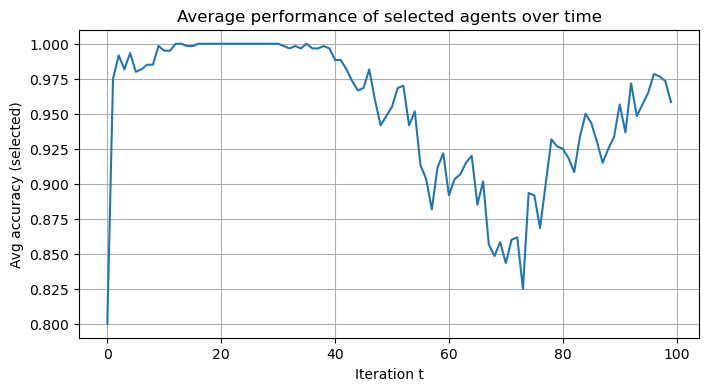

In [147]:
# Plotting trends
plt.figure(figsize=(8,4))
plt.plot(df_records['t'], df_records['avg_perf_selected'])
plt.title("Average performance of selected agents over time")
plt.xlabel("Iteration t")
plt.ylabel("Avg accuracy (selected)")
plt.grid(True)
plt.show()



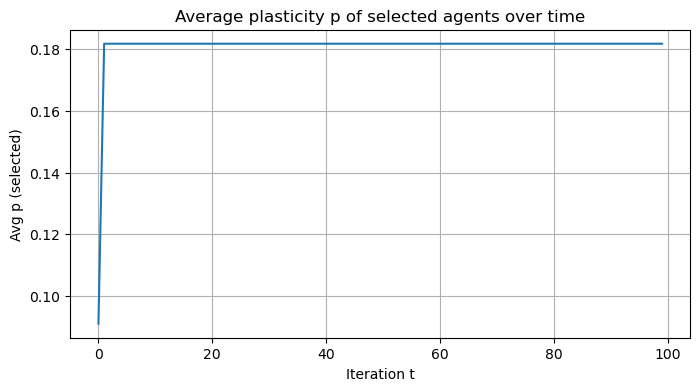

In [148]:
plt.figure(figsize=(8,4))
plt.plot(df_records['t'], df_records['avg_p_selected'])
plt.title("Average plasticity p of selected agents over time")
plt.xlabel("Iteration t")
plt.ylabel("Avg p (selected)")
plt.grid(True)
plt.show()

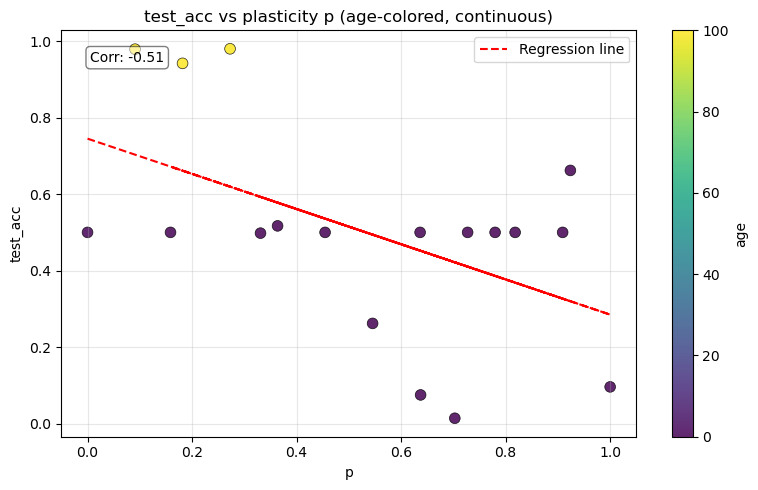

In [149]:
# ...existing code...
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# Map ages to a continuous colormap (viridis) and include colorbar
cmap = plt.get_cmap('viridis')
age_vals = df_perf['age'].astype(float)
norm = plt.Normalize(vmin=age_vals.min(), vmax=age_vals.max())

plt.figure(figsize=(8,5))
sc = plt.scatter(
    df_perf['p'], df_perf['test_acc'],
    c=age_vals, cmap=cmap, norm=norm,
    s=60, edgecolor='k', linewidth=0.5, alpha=0.85
)
plt.xlabel('p')
plt.ylabel('test_acc')
plt.title('test_acc vs plasticity p (age-colored, continuous)')
plt.grid(True, alpha=0.3)

#set regression line
z = np.polyfit(df_perf['p'], df_perf['test_acc'], 1)
p_line = np.poly1d(z)
plt.plot(df_perf['p'], p_line(df_perf['p']), color='red', linestyle='--', label='Regression line')
#correlaton coefficient
corr_coef = np.corrcoef(df_perf['p'], df_perf['test_acc'])[0,1]
plt.text(0.05, 0.95, f'Corr: {corr_coef:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.legend()
# colorbar for continuous ages
cbar = plt.colorbar(sc)
cbar.set_label('age')

# ensure results directory exists before saving
Path('./results').mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig('./results/df_perf_scatter.png', dpi=200, bbox_inches='tight')
plt.show()
# ...existing code...

In [128]:
!mkdir -p results

In [129]:
# Save succinct CSV outputs
df_records.to_csv('./results/meta_records.csv', index=False)
df_perf.to_csv('./results/agent_performance.csv', index=False)
agg.to_csv('./results/agg_per_pgroup.csv', index=False)

print("\nSaved CSVs: meta_records.csv, agent_performance.csv, agg_per_pgroup.csv")




Saved CSVs: meta_records.csv, agent_performance.csv, agg_per_pgroup.csv
